# Final Project - Improved Curveball

Hey my name is Collin Moe, and this is the Final project from my Computational Physics class. In this project my goal was to improve upon my previous project 2 (curveball project) in which i was able to model a realistic curveball involving air resistance and drag. Because of this much of my project is the same as previous but my final goal in this was to create a spray chart of curveballs to show off the different velocity, spinrate, and spin angles and how they affect the ball on a single chart.

In [22]:
import ode #ode.py should be in the same folder as your notebook
import numpy as np
import matplotlib.pyplot as plt
from vpython import * 
from scipy.linalg import eigh
from IPython.display import display, Markdown, Latex
from IPython.display import HTML
from mplEasyAnimate import animation
from tqdm import tqdm
from base64 import b64encode

In this following cell is where i declare the parameters or the constants in my equations. Certain things like the cross-sectional area and the mass, as well as the gravitional constant etc.

In [23]:
#parameters
g = 9.8 #N/kg\
rho = 1.2 #kg/m^3
mu = 1.8e-5 #kg/m/s
r = 74e-3/2 #74 mm diameter, 9.25" in circumference
A = np.pi*r**2 #cross-sectional area
Cd = 0.3 #depends on speed
m = 0.145 #kg

#b2 = 1/2*Cd*rho*A #changes as Cd changes

S = 0.01 #will change as omega and v change
CL = 0 #will change with S
#alpha = 1/2*CL*rho*A*r/S

# Main Function/Equations

In this following cell I use the same derivative approach throught the RK4 function in the ODE file that I have used on the previous projects. In this function I most importantly have the equations for the interactions between the ball and air and how that effects velocity and spin. For example I have the equations for the Magnus Effect as well as drag using the drag coefficient. However because this is in a 3d cordinate system i need to account for the X,Y, as well a Z axis.

In [29]:
def forcesoftheball(d, t):
    """ Calculate and return the derivative of each quantity in an array d at the time t.
   
    Keyword arguments:
    t -- time at the beginning of the time step
    d -- an array of variables at time t
    """
   
    x = d[0]
    y = d[1]
    z = d[2]
    vx = d[3]
    vy = d[4]
    vz = d[5]
    
    dxdt = vx
    dydt = vy
    dzdt = vz
    
    v = np.sqrt(vx**2 + vy**2 + vz**2)
    
    #drag
    a = 0.36
    b = 0.14
    c = 0.27
    vc = 34
    chi = (v-vc)/4
    
    if chi < 0:
        Cd = a + b/(1+np.exp(chi)) - c*np.exp(-chi**2)
    else:
        Cd = a + b/(1+np.exp(chi)) - c*np.exp(-chi**2/4)
    
    b2 = 1/2*Cd*rho*A
    Fdragx = -b2*v**2*vx/v
    Fdragy = -b2*v**2*vy/v
    Fdragz = -b2*v**2*vz/v
    
    #magnus
    omegax = d[6]
    omegay = d[7]
    omegaz = d[8]
    omegamag = np.sqrt(omegax**2 + omegay**2 + omegaz**2)
    S = r*omegamag/v
    CL = 0.62*S**0.7
    alpha = 1/2*CL*rho*A*r/S
    Fmagnusx = alpha*(omegay*vz - omegaz*vy)
    Fmagnusy = alpha*(omegaz*vx - omegax*vz)
    Fmagnusz = alpha*(omegax*vy - omegay*vx)
    
    #grav
    Fgravy = -m*g
    
    #Fnet
    Fnetx = Fdragx + Fmagnusx
    Fnety = Fdragy + Fmagnusy + Fgravy
    Fnetz = Fdragz + Fmagnusz
    
    #derivative of velocity
    dvxdt = Fnetx/m
    dvydt = Fnety/m
    dvzdt = Fnetz/m
    
    derivs = np.array([dxdt, dydt, dzdt, dvxdt, dvydt, dvzdt, 0, 0, 0])
   
    return derivs

# The Looping

In this following cell I start by creating a function so that later I will be able to call this function with a set of parameters that will be the three variables that I will be changing in the future, Velocity, Spinrate, and Spin angle. following this I started declaring some of the initial variables as well as my used time step, which needed to be a very short time step due to the speed of a pitch and we need an accurate measure. I mark the Velocity at 79.3 mph an average curveball velocity, I then change that into meters per second as we will be using meters as the base measure. I also had to get the corect spin rate as well as the angle of the spin which would be 45 degrees about the x-axis so that it would be a perfect diagnol spin rate. I also create the lists needed to keep track of the variables. In the loop I call the previous function using the RK method as well to do the calculations and keep the loop going until the ball reaches the plate at 20.2 meters. Following this I graph the x and y displacement as well as the Z and y displacement.

In [25]:
def runspin(spin, velo, tdeg):
    t = 0 #time in s
    h = .008 #time step in s

    # data for pitch
    vmag0mph = velo #mph
    thetadeg = 1 #degx
    spinrate = spin

    # convert units and create initial conditions
    vmag0 = vmag0mph*0.44704 #convert mph to m/s
    theta = thetadeg*np.pi/180 #convert deg to rad

    x0 = 0
    y0 = 0
    z0 = 0
    vx0 = 0
    vy0 = vmag0*np.sin(theta)   
    vz0 = vmag0*np.cos(theta)

    # initial angular speed and velocity
    omegamag = spinrate * 2*np.pi / 60 #convert to rad/s
    thetaomega = tdeg*pi/180
    omega = omegamag*np.array([np.cos(thetaomega), sin(thetaomega), 0]) #omegacostheta , omegasintheta for angled pitches
    #omega = np.array([-omegamag*np.cos(theta), -omegamag*np.sin(theta), 0])
    # array for instanomega = np.array([-omegamag, 0, 0])taneous position and velocity data
    data = np.array([x0, y0, z0, vx0, vy0, vz0, omega[0], omega[1], omega[2]])

    # lists for storing data to graph
    tlist = []
    xlist = []
    ylist = []
    zlist = []

    # store initial values
    tlist.append(t)
    xlist.append(x0)
    ylist.append(y0)
    zlist.append(z0)

    z = z0

    while z < 20.2:

        data = ode.RK4(forcesoftheball, data, t, h)
        t = t + h

        x = data[0]
        y = data[1]
        z = data[2]
        tlist.append(t)
        xlist.append(x)
        ylist.append(y)
        zlist.append(z)

    return xlist[-1],ylist[-1]

This is the Cell in which I declare my final x and y lists to plot for the end point of each curveball, after doing this I ran 3 for loops that would loop through each variable to get every possible combination. So that the spray chart will have a large variety of points

In [26]:
xfinal = []
yfinal = []
for thdeg in np.arange(25,65,10):
    for ve in np.arange(69,85,2):
        for s in np.arange(1500,3000,100):
            x,y = runspin(s,ve,thdeg)
            xfinal.append(x)
            yfinal.append(y)

# Plotting

In this cell I plot the final spray chart using the x and y final lists conatinaing all of the final positions in those axis

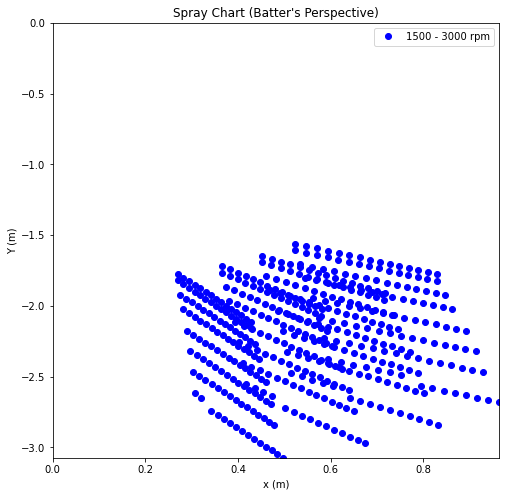

In [27]:
# Plot the spray chart
plt.figure(figsize = (8,8))
plt.title("Spray Chart (Batter's Perspective)")
plt.xlabel("x (m)")
plt.ylabel("Y (m)")
plt.plot(xfinal, yfinal, 'bo', label = "1500 - 3000 rpm")
plt.xlim(0,np.max(xfinal))
plt.ylim(np.min(yfinal),0)
plt.legend()
plt.show()



In this cell i simply took my same code from my previous project which is also the same from above but instead i have a set velocity, angle and spin rate, and I plot every time step so that you guys can see the motion of the base curveball similiar to that of the previous project.

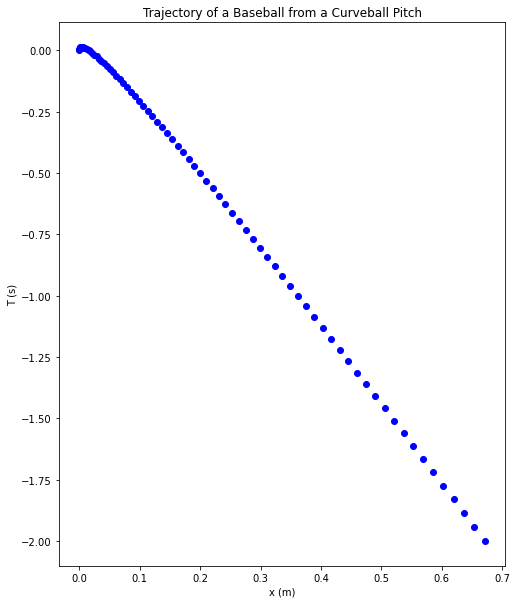

In [28]:
t = 0 #time in s
h = .008 #time step in s

# data for pitch
vmag0mph = 79.3 #mph
thetadeg = 1 #degx
spinrate = 2548

# convert units and create initial conditions
vmag0 = vmag0mph*0.44704 #convert mph to m/s
theta = thetadeg*np.pi/180 #convert deg to rad

x0 = 0
y0 = 0
z0 = 0
vx0 = 0
vy0 = vmag0*np.sin(theta)   
vz0 = vmag0*np.cos(theta)

# initial angular speed and velocity
omegamag = spinrate * 2*np.pi / 60 #convert to rad/s
thetaomega = 45*np.pi/180
omega = omegamag*np.array([np.cos(thetaomega), np.sin(thetaomega), 0]) #omegacostheta , omegasintheta for angled pitches
#omega = np.array([-omegamag*np.cos(theta), -omegamag*np.sin(theta), 0])
# array for instanomega = np.array([-omegamag, 0, 0])taneous position and velocity data
data = np.array([x0, y0, z0, vx0, vy0, vz0, omega[0], omega[1], omega[2]])

# lists for storing data to graph
tlist = []
xlist = []
ylist = []
zlist = []

# store initial values
tlist.append(t)
xlist.append(x0)
ylist.append(y0)
zlist.append(z0)

z = z0

while z < 20.2:

    data = ode.RK4(forcesoftheball, data, t, h)
    t = t + h

    x = data[0]
    y = data[1]
    z = data[2]
    tlist.append(t)
    xlist.append(x)
    ylist.append(y)
    zlist.append(z)

plt.figure(figsize = (8,10))
plt.title("Trajectory of a Baseball from a Curveball Pitch")
plt.xlabel("x (m)")
plt.ylabel("T (s)")
plt.plot(xlist, ylist, 'bo')
plt.show()